# Effect of Class Time on Grades, For Math Classes

Alexander Bailey, Kayli Leung

# Methodology
We will perform a two-tail, two-sample t-test on the data. Using [Kaggle's UW Madison Grade's Database](https://www.kaggle.com/Madgrades/uw-madison-courses#schedules.csv).

## Question

Is a significant difference in the percentage of A's given based on whether a class starts before noon or after noon, given that the class is a math class. 

## Hypotheses
We select an alpha value of 0.05.

Null Hypothesis: There is no significant difference in the mean percentage of A's in the morning classes and afternoon math classes.

Alternate Hypothesis: There is a significant difference in the mean percentage of A's in the morning and afternoon math classes.

Class start and end time is listed in minutes from midnight.

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
import numpy as np
import scipy.stats as stats

In [2]:
conn = psycopg2.connect("host=localhost,dbname=postgres,user=postgres")

cur = conn.cursor()

In [3]:
group_and_as = """
SELECT 
  grade.a_count
, grade.ab_count
, grade.b_count
, grade.bc_count
, grade.c_count
, grade.d_count
, grade.f_count
, sched.start_time
, sect.section_type
, grade.course_offering_uuid
, grade.section_number
, sub.name
FROM 
  sections sect
INNER JOIN 
  schedules sched 
ON 
  sched.uuid = sect.schedule_uuid
INNER JOIN 
  grade_distributions grade 
ON 
  sect.number = grade.section_number
INNER JOIN
  subject_memberships sub_m
ON
  sub_m.course_offering_uuid = sect.course_offering_uuid
INNER JOIN
  subjects sub
ON
  sub.code = sub_m.subject_code
AND 
  sect.course_offering_uuid = grade.course_offering_uuid
WHERE
  sub.name = 'Mathematics';
"""

In [4]:
cur.execute(group_and_as)
df = pd.DataFrame(cur.fetchall())
df.columns = [i[0] for i in cur.description]
df['total_count'] = (df['a_count'] + df['ab_count'] + df['b_count'] + df['bc_count'] 
                     + df['c_count'] + df['d_count'] + df['f_count'])
df.head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,section_type,course_offering_uuid,section_number,name,total_count
0,0,1,3,2,6,6,5,595,LEC,cd055dc8-5f49-3c89-92ac-0929d6a81084,2,Mathematics,23
1,2,1,1,2,2,2,1,660,LEC,7f8ded97-695f-326e-97f1-a62293258178,1,Mathematics,11
2,2,1,4,1,3,1,0,800,LEC,7f8ded97-695f-326e-97f1-a62293258178,2,Mathematics,12
3,2,2,8,2,2,0,1,595,LEC,c9a679c5-8852-3cf7-94b2-917f5e749f58,1,Mathematics,17
4,3,1,0,4,5,0,2,800,LEC,c9a679c5-8852-3cf7-94b2-917f5e749f58,2,Mathematics,15


In [5]:
df.sort_values(by='start_time').head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,section_type,course_offering_uuid,section_number,name,total_count
2880,0,0,0,0,0,0,0,-1,IND,1851b810-dac9-374e-81de-18ec02323f7a,18,Mathematics,0
2836,0,0,0,0,0,0,0,-1,IND,43729f49-eb48-37cf-b37a-a001554c9263,38,Mathematics,0
2835,0,0,0,0,0,0,0,-1,IND,43729f49-eb48-37cf-b37a-a001554c9263,67,Mathematics,0
2834,0,0,0,0,0,0,0,-1,IND,1851b810-dac9-374e-81de-18ec02323f7a,106,Mathematics,0
2833,0,0,0,0,0,0,0,-1,IND,7e7dd109-ed5c-32b9-9b96-60ab1860d4fa,159,Mathematics,0


In [6]:
df.loc[df['start_time'] != -1, 'section_type'].value_counts()

LEC    2843
SEM     112
DIS      46
Name: section_type, dtype: int64

All the independent studies are -1. As all these values are no use to our test (because we are interested in start time) we will drop all start_times of -1. We will also cut of irregular times (classes that start before 6AM) because these are potentially errors during input. We can also drop section types that are irregular or tied to other classes, like Labs.  

In [7]:
df = df[df['start_time'] >= 360]
df = df[df['section_type'] != 'IND']
df = df[df['section_type'] != 'FLD']
df = df[df['section_type'] != 'LAB']
df = df[df['section_type'] != 'DIS']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2955 entries, 0 to 3534
Data columns (total 13 columns):
a_count                 2955 non-null int64
ab_count                2955 non-null int64
b_count                 2955 non-null int64
bc_count                2955 non-null int64
c_count                 2955 non-null int64
d_count                 2955 non-null int64
f_count                 2955 non-null int64
start_time              2955 non-null int64
section_type            2955 non-null object
course_offering_uuid    2955 non-null object
section_number          2955 non-null int64
name                    2955 non-null object
total_count             2955 non-null int64
dtypes: int64(10), object(3)
memory usage: 323.2+ KB


In [8]:
df.sort_values(by='total_count').head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,section_type,course_offering_uuid,section_number,name,total_count
2551,0,0,0,0,0,0,0,800,SEM,298df9e6-5033-355d-8e7c-e5d807de66fa,2,Mathematics,0
2427,0,0,0,0,0,0,0,660,LEC,632d128b-560c-38d7-84a4-fce42d90e735,1,Mathematics,0
528,0,0,0,0,0,0,0,530,LEC,2f65dd14-6217-38f6-8311-4fa0671ce06e,15,Mathematics,0
2430,0,0,0,0,0,0,0,595,LEC,da7b1ca2-6b51-3a83-8370-bdb6c0014423,1,Mathematics,0
2431,0,0,0,0,0,0,0,865,LEC,8e962742-6181-36fa-a0ca-160da959200d,1,Mathematics,0


There are still a number of classes that have no students. We want to drop these as it is not reflective of our study.

In [9]:
df = df[df['total_count'] != 0]

In [10]:
df['total_count'].value_counts().head()

22    125
19    117
20    115
21    109
17     92
Name: total_count, dtype: int64

In [11]:
df2 = df.copy()

In [12]:
df2['ratio_of_as'] = df['a_count'] / df['total_count']

In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2823 entries, 0 to 3534
Data columns (total 14 columns):
a_count                 2823 non-null int64
ab_count                2823 non-null int64
b_count                 2823 non-null int64
bc_count                2823 non-null int64
c_count                 2823 non-null int64
d_count                 2823 non-null int64
f_count                 2823 non-null int64
start_time              2823 non-null int64
section_type            2823 non-null object
course_offering_uuid    2823 non-null object
section_number          2823 non-null int64
name                    2823 non-null object
total_count             2823 non-null int64
ratio_of_as             2823 non-null float64
dtypes: float64(1), int64(10), object(3)
memory usage: 330.8+ KB


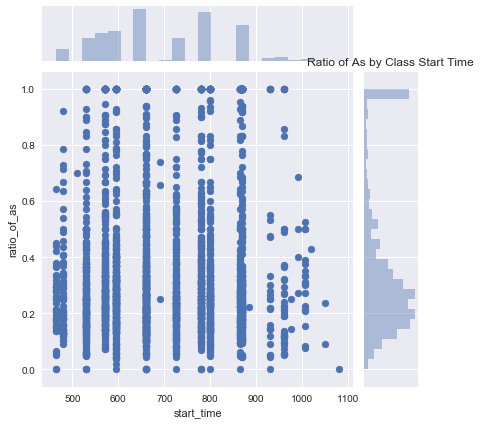

In [14]:
sns.jointplot('start_time', 'ratio_of_as',df2)
plt.title('Ratio of As by Class Start Time')
plt.show();

In [15]:
df2.drop_duplicates(inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2661 entries, 0 to 3534
Data columns (total 14 columns):
a_count                 2661 non-null int64
ab_count                2661 non-null int64
b_count                 2661 non-null int64
bc_count                2661 non-null int64
c_count                 2661 non-null int64
d_count                 2661 non-null int64
f_count                 2661 non-null int64
start_time              2661 non-null int64
section_type            2661 non-null object
course_offering_uuid    2661 non-null object
section_number          2661 non-null int64
name                    2661 non-null object
total_count             2661 non-null int64
ratio_of_as             2661 non-null float64
dtypes: float64(1), int64(10), object(3)
memory usage: 311.8+ KB


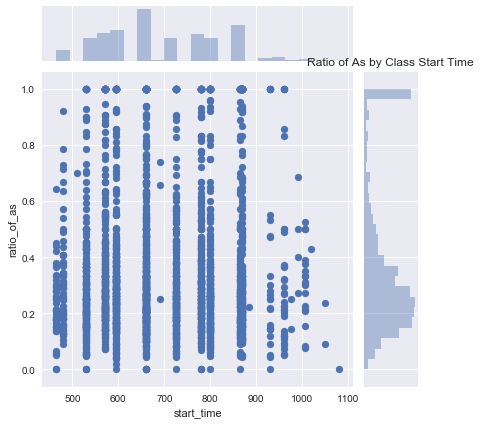

In [16]:
sns.jointplot('start_time', 'ratio_of_as',df2)
plt.title('Ratio of As by Class Start Time')
plt.show();

In [17]:
df2['section_type'].value_counts()

LEC    2629
SEM      32
Name: section_type, dtype: int64

In [18]:
morning_df = df2.loc[df2['start_time'] < 720]
afternoon_df = df2.loc[df2['start_time'] >= 720]

In [19]:
morning_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1467 entries, 0 to 3531
Data columns (total 14 columns):
a_count                 1467 non-null int64
ab_count                1467 non-null int64
b_count                 1467 non-null int64
bc_count                1467 non-null int64
c_count                 1467 non-null int64
d_count                 1467 non-null int64
f_count                 1467 non-null int64
start_time              1467 non-null int64
section_type            1467 non-null object
course_offering_uuid    1467 non-null object
section_number          1467 non-null int64
name                    1467 non-null object
total_count             1467 non-null int64
ratio_of_as             1467 non-null float64
dtypes: float64(1), int64(10), object(3)
memory usage: 171.9+ KB


In [20]:
afternoon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1194 entries, 2 to 3534
Data columns (total 14 columns):
a_count                 1194 non-null int64
ab_count                1194 non-null int64
b_count                 1194 non-null int64
bc_count                1194 non-null int64
c_count                 1194 non-null int64
d_count                 1194 non-null int64
f_count                 1194 non-null int64
start_time              1194 non-null int64
section_type            1194 non-null object
course_offering_uuid    1194 non-null object
section_number          1194 non-null int64
name                    1194 non-null object
total_count             1194 non-null int64
ratio_of_as             1194 non-null float64
dtypes: float64(1), int64(10), object(3)
memory usage: 139.9+ KB


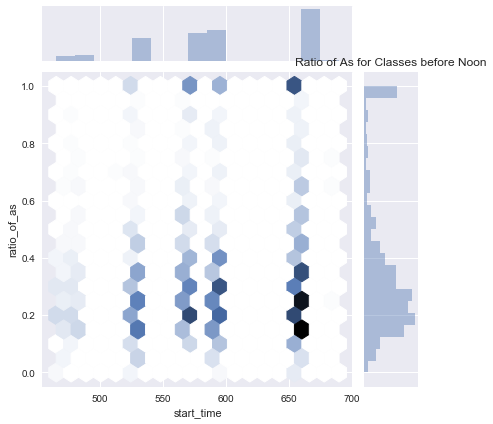

In [21]:
sns.jointplot('start_time', 'ratio_of_as',morning_df,kind='hex')
plt.title('Ratio of As for Classes before Noon')
plt.show();

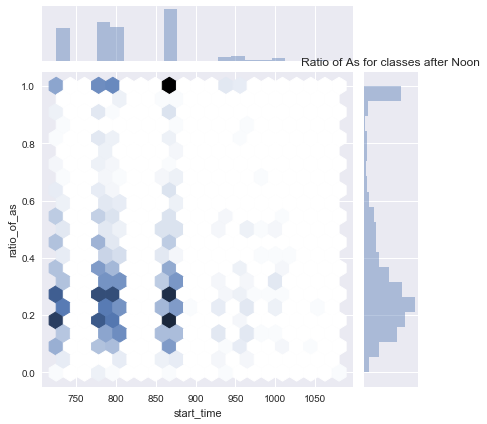

In [22]:
sns.jointplot('start_time', 'ratio_of_as',afternoon_df,kind='hex')
plt.title('Ratio of As for classes after Noon')
plt.show();

# Determine Sample Size

In [23]:
moe = 0.1
z = 1.96 # z value for alpha 0.05
morn_var = np.var(morning_df['ratio_of_as'])
morn_n = len(morning_df['ratio_of_as'])
aft_var = np.var(afternoon_df['ratio_of_as'])
aft_n = len(afternoon_df['ratio_of_as'])

num = (morn_n - 1) * morn_var + (aft_n - 1) * aft_var
den = morn_n + aft_n - 2
pooled_std = np.sqrt(num/den)

In [24]:
n = 2 * (z * pooled_std / moe)**2
n

55.0977977250434

We will use samples from morning and afternoon of size 68.

In [25]:
np.random.seed(20)

morning = morning_df['ratio_of_as']
afternoon = afternoon_df['ratio_of_as']

morning_sample = np.random.choice(morning, size=57)
afternoon_sample = np.random.choice(afternoon, size=57)

In [26]:
stats.ttest_ind(morning_sample, afternoon_sample)

Ttest_indResult(statistic=-0.4532305528633009, pvalue=0.6512595979228706)

Our p-value is about 0.407 which is greater than our alpha of 0.05. This means that we cannot reject the null hypothesis. Even when we look only at math classes we still cannot say that there is a statistical difference in the ratio of A's of a class depending on if the class is before or after noon. 

If we want to improve our schedules to increase the percentage of A's we will need to look at other factors.